# Am I the AHole Dataset Construction

Constructing datasets for the AITA subreddit as an exercise using AllenNLP.

In [211]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../aita')

import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact
import statsmodels.api as sm
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

## Data Loading

Loads the data from sharded files, need to rebuild and concatonate.
May take up a lot of memory, so runon a computer with enough RAM.

In [136]:
train_path = Path.cwd().parent / "aita" / "aita-train.pkl"
test_path = Path.cwd().parent / "aita" / "aita-test.pkl"

In [137]:
train_df = pd.read_pickle(train_path)
test_df = pd.read_pickle(test_path)

In [138]:
train_df.label.value_counts()

NTA    12611
YTA     7448
NAH     1308
ESH      734
Name: label, dtype: int64

In [139]:
test_df.label.value_counts()

NTA    1770
YTA    1019
NAH     175
ESH     106
Name: label, dtype: int64

In [140]:
def add_features(df):
    df['log_num_comments'] = np.log(df.num_comments)
    df['log_score'] = np.log(abs(df.score) + 0.001)
    df['title_len'] = df.title.map(lambda x: len(x.split()))
    df['body_len'] = df.selftext.map(lambda x: len(x.split()))
    df['log_title_len'] = np.log(df.title_len + 0.001)
    df['log_body_len'] = np.log(df.body_len + 0.001)
    return df

In [141]:
train_df = add_features(train_df)
test_df = add_features(test_df)

In [142]:
columns = [a for a in train_df.columns if np.issubdtype(train_df[a].dtype, np.number)]

@interact
def distributions(col=columns):
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=col, y='label', data=train_df)
    plt.show()

interactive(children=(Dropdown(description='col', options=('author_created_utc', 'created_utc', 'downs', 'gild…

## Glove Embeddings

Try simple feedforward NN with glove embeddings.
Will also try some embedding for some nice visualizations.

In [153]:
from sklearn.manifold import TSNE
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.utils.data as data_utils

In [145]:
%%bash
wget -nc http://nlp.stanford.edu/data/glove.6B.zip
unzip -n glove.6B.zip

Archive:  glove.6B.zip


File ‘glove.6B.zip’ already there; not retrieving.



In [146]:
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [147]:
embedding_size = len(embeddings_dict['at'])

In [148]:
def convert_title_to_embedding(title):
    embeddings = [
        embeddings_dict[word.lower()]
        for word in title.split()
        if word.lower() in embeddings_dict
    ]
    if embeddings:
        glove_embeddings = np.stack(embeddings).mean(axis=0)
    else:
        glove_embeddings = np.zeros(embedding_size)
    return glove_embeddings

In [149]:
train_df['title_emb'] = train_df.title.map(convert_title_to_embedding)
test_df['title_emb'] = test_df.title.map(convert_title_to_embedding)

In [199]:
feature_cols = ['title_emb', 'log_title_len', 'log_body_len', 'num_comments', 'log_num_comments']
features_train = np.array(
    train_df[feature_cols].apply(
        lambda x: np.hstack([np.array(a) for a in x]), axis=1).tolist()
)

In [200]:
tsne = TSNE(n_components=2, verbose=True)
Y = tsne.fit_transform(features_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22101 samples in 0.566s...
[t-SNE] Computed neighbors for 22101 samples in 29.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22101
[t-SNE] Computed conditional probabilities for sample 2000 / 22101
[t-SNE] Computed conditional probabilities for sample 3000 / 22101
[t-SNE] Computed conditional probabilities for sample 4000 / 22101
[t-SNE] Computed conditional probabilities for sample 5000 / 22101
[t-SNE] Computed conditional probabilities for sample 6000 / 22101
[t-SNE] Computed conditional probabilities for sample 7000 / 22101
[t-SNE] Computed conditional probabilities for sample 8000 / 22101
[t-SNE] Computed conditional probabilities for sample 9000 / 22101
[t-SNE] Computed conditional probabilities for sample 10000 / 22101
[t-SNE] Computed conditional probabilities for sample 11000 / 22101
[t-SNE] Computed conditional probabilities for sample 12000 / 22101
[t-SNE] Computed conditional probabilities for sa

In [249]:
train_df['tsne-2d-one'] = Y[:,0]
train_df['tsne-2d-two'] = Y[:,1]

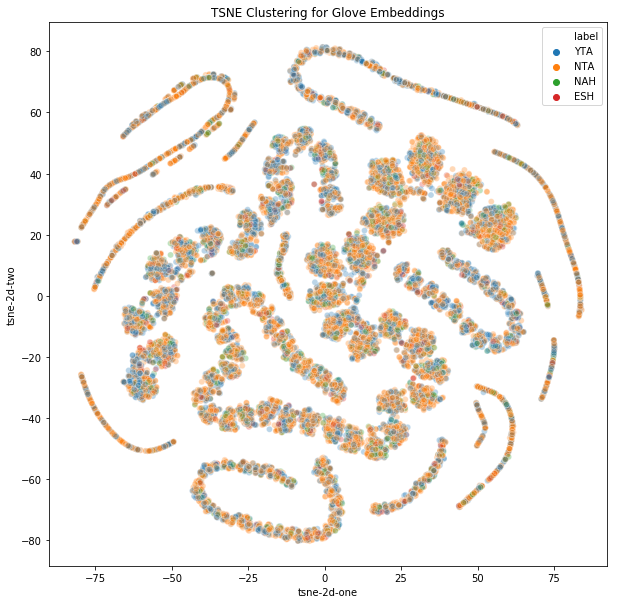

In [255]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    data=train_df,
    legend="full",
    alpha=0.3
)
plt.title("TSNE Clustering for Glove Embeddings")
plt.show()

### Simple Feedforward

### Roberta Embeddings